In [1]:

import pandas as pd

from sklearn.externals import joblib
# Added version check for recent scikit-learn 0.18 checksok ca
from distutils.version import LooseVersion as Version
import numpy as np
from dateutil.parser import parse
import datetime as dt
from numba import jit
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import precision_recall_fscore_support 
from tqdm import tqdm, tqdm_notebook

from collections import OrderedDict
import pickle 
import matplotlib.pyplot as plt
import seaborn as sns
import random, os, csv      # random is the rng, os is the operating system, and csv handles
                            # CSV files
import matplotlib.pyplot as plt  # This is the plotter
import time                 # This allows for lots of neat tricks.
import powerlaw
import mpmath
# import visual tools
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns

plt.style.use('seaborn-talk')
plt.style.use('bmh')

#plt.rcParams['font.family'] = 'DejaVu Sans Mono'
#plt.rcParams['font.size'] = 9.5
plt.rcParams['font.weight'] = 'medium'
#plt.rcParams['figure.figsize'] = 10,7
blue, green, red, purple, gold, teal = sns.color_palette('colorblind', 6)



In [2]:
def returns(s):
    #compute log returns
    arr = np.diff(np.log(s))
    return (pd.Series(arr, index=s.index[1:]))

def tick_bars(df, price_column, m):
    '''
    compute tick bars
    # args
        df: pd.DataFrame()
        column: name for price data
        m: int(), threshold value for ticks
    # returns
        idx: list of indices
    '''
    t = df[price_column]
    ts = 0
    idx = []
    for i, x in enumerate(tqdm(t)):
        ts += 1
        if ts >= m:
            idx.append(i)
            ts = 0
            continue
    return idx
def tick_bar_df(df, price_column, m):
    idx = tick_bars(df, price_column, m)
    return df.iloc[idx]
#========================================================
def volume_bars(df, volume_column, m):
    '''
    compute volume bars
    # args
        df: pd.DataFrame()
        column: name for volume data
        m: int(), threshold value for volume
    # returns
        idx: list of indices
    '''
    t = df[volume_column]
    ts = 0
    idx = []
    for i, x in enumerate(tqdm(t)):
        ts += x
        if ts >= m:
            idx.append(i)
            ts = 0
            continue
    return idx

def volume_bar_df(df, volume_column, m):
    idx = volume_bars(df, volume_column, m)
    return df.iloc[idx]
#========================================================
def dollar_bars(df, dv_column, m):
    '''
    compute dollar bars
    # args
        df: pd.DataFrame()
        column: name for dollar volume data
        m: int(), threshold value for dollars
    # returns
        idx: list of indices
    '''
    t = df[dv_column]
    ts = 0
    idx = []
    for i, x in enumerate(tqdm(t)):
        ts += x
        if ts >= m:
            idx.append(i)
            ts = 0
            continue
    return idx

def dollar_bar_df(df, dv_column, m):
    idx = dollar_bars(df, dv_column, m)
    return df.iloc[idx]
#========================================================
dataparser = lambda x: pd.datetime.strptime(x, '%M:%S.%f').time
#========================================================
@jit(nopython=True)
def mad_outlier(y, thresh=3.):
    '''
    compute outliers based on mad
    # args
        y: assumed to be array with shape (N,1)
        thresh: float()
    # returns
        array index of outliers
    '''
    median = np.median(y)
    diff = np.sum((y - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh


In [3]:
os.getcwd()
data_dir = os.getenv('FINANCE_DATA')  # main directory referenced in all the code
data_only_drive = '/mnt/usb-Seagate_Expansion_Desk_NA8XEHR6-0:0-part2/FinData/'  # external date only drive
quotes=[s for s in os.listdir(data_only_drive) if s.endswith('quotes')]
trades=[s for s in os.listdir(data_only_drive) if s.endswith('trades')]
TY1_trades=[s for s in os.listdir(data_only_drive) if s.startswith('TY1') and s.endswith('trades')]
TY1_quotes=[s for s in os.listdir(data_only_drive) if s.startswith('TY1') and s.endswith('quotes')]

In [4]:
import os
data_drive='/mnt/usb-Seagate_Expansion_Desk_NA8XEHR6-0:0-part2/'
clean_files_data = "".join((data_drive,'/BTCUSD.PERP.BMEX/'))
raw_crypto_data = '/mnt/usb-Seagate_Expansion_Desk_NA8XEHR6-0:0-part2/Data/crypto/LOB/BTCUSD.PERP.BMEX/' #btc perp data
clean_crypto_files = os.listdir(clean_files_data)

In [5]:
filename = "".join((clean_files_data,clean_crypto_files[0]))
df_crypto=pd.read_csv(filename)

In [ ]:
# ty1_quotes_loc="".join((data_only_drive,TY1_quotes[0]))
# ty1_trades_loc="".join((data_only_drive,TY1_trades[0]))

In [ ]:
# futures_data_folder= '/home/ak/Documents/Data/FuturesData/'
loc=ty1_quotes_loc
csv_files=[s for s in os.listdir(loc) if s.endswith('.csv')]

In [ ]:
csv_idx=1
csv_loc = "/".join((loc,csv_files[csv_idx]))
raw_data=pd.read_csv(csv_loc)
raw_data.columns.values
# raw_data=raw_data.rename(columns={'Unnamed: 0':'TimeStamp'})
raw_data.reset_index(inplace=True)
raw_data=raw_data.drop(columns=['index','Unnamed: 0'])

In [ ]:
raw_data.columns.values

In [ ]:
raw_data.head(10)
bids=raw_data[raw_data['type']=='BID'].rename(columns={'size': 'bestBidSize', 'time': 'bidTimeStamp','value':'bestBidPrice'})
asks=raw_data[raw_data['type']=='ASK'].rename(columns={'size': 'bestAskSize', 'time': 'askTimeStamp','value':'bestAskPrice'})
df=pd.concat([bids, asks], axis=1)
df=df.fillna(method='ffill').dropna()
df['bidTimeStamp']=pd.to_datetime(df['bidTimeStamp'])
df['askTimeStamp']=pd.to_datetime(df['askTimeStamp'])

In [ ]:
# # df = pd.DataFrame(raw_data.row.str.split('',1).tolist(),
# #                                    columns = ['BID','ASK'])
# raw_data['type'].str.split('', 1, expand=True)


In [ ]:
new_dates, new_times = zip(*[(d.date(), d.time()) for d in df['askTimeStamp']])
# df = df.assign(df.askTimeStamp = new_times)


In [7]:
df_crypto.drop('Unnamed: 0', axis=1, inplace=True)

In [8]:
df_crypto.head(5)

,bestBidPrice,bestBidSize,bestAskPrice,bestAskSize,timestamp,time,date,milliSeconds,duration,MicroPrice,MicroPriceReturns
0,6696.5,1176546.0,6697.0,426856.0,2018-08-26 13:21:37.905000+00:00,13:21:37.905000,2018-08-26,48097000.0,0.0,6696.633109,0.000000e+00
1,6696.5,1176646.0,6697.0,426856.0,2018-08-26 13:21:38.017000+00:00,13:21:38.017000,2018-08-26,48098000.0,1000.0,6696.633101,-1.239604e-09
2,6696.5,1176296.0,6697.0,426856.0,2018-08-26 13:21:38.304000+00:00,13:21:38.304000,2018-08-26,48098000.0,0.0,6696.633130,4.339290e-09
3,6696.5,1176296.0,6697.0,424112.0,2018-08-26 13:21:38.338000+00:00,13:21:38.338000,2018-08-26,48098000.0,0.0,6696.632501,-9.393097e-08
4,6696.5,1176296.0,6697.0,424112.0,2018-08-26 13:21:38.465000+00:00,13:21:38.465000,2018-08-26,48098000.0,0.0,6696.632501,0.000000e+00


df['milliSeconds']=[int(((x.hour*60 + x.minute)*60 + x.second)*1000) for x in df['TimeStamp']]

df=df.drop(columns=['bidTimeStamp','askTimeStamp', 'type'])


In [ ]:
# from StringIO import StringIO
# in_ = StringIO()
# in_.write(raw_data['TimeStamp'])
# in_.seek(0)


In [ ]:
df=micro_price(df)

In [10]:

# raw_data['TimeStamp'].dt.time
# raw_data['TimeStamp']=pd.to_datetime(raw_data['TimeStamp'])
df_crypto['logRetMicroPrice']=returns(df_crypto.MicroPrice)
df=df_crypto.dropna()

In [ ]:
# raw_data['milliSeconds']=[int(((x.hour*60 + x.minute)*60 + x.second)*1000) for x in raw_data['TimeStamp']]
# raw_data['Duration']= raw_data['milliSeconds'].diff(1)
# raw_data=raw_data.dropna()
df.columns.values

In [ ]:
# for x in range(raw_data.shape[0]):
#     t= raw_data['TimeStamp'][x]
#     print (t.hour*60 + t.minute)*60 + t.second 

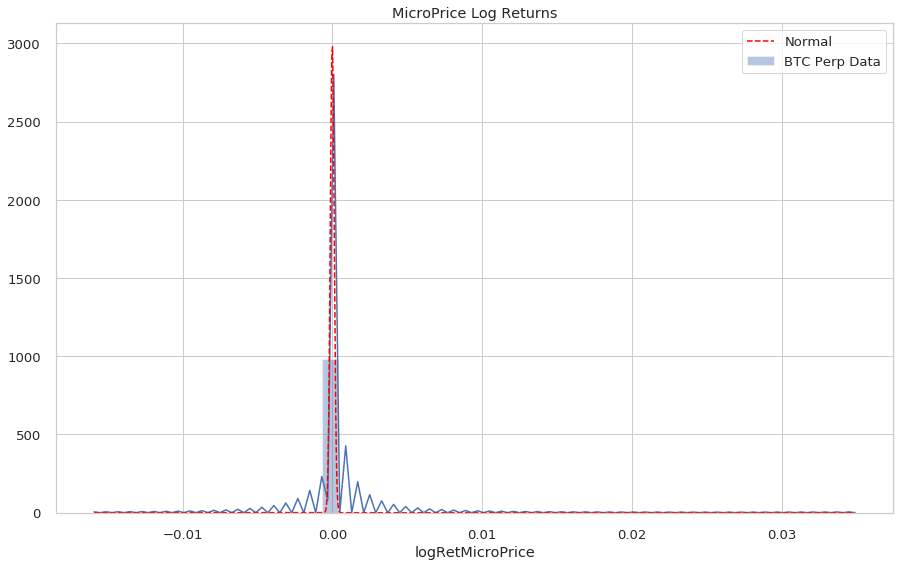

In [11]:
from scipy.stats import norm
x = np.linspace(np.min(df.logRetMicroPrice),np.max(df.logRetMicroPrice),1000)
y = norm.pdf(x, loc=np.mean(df.logRetMicroPrice), scale=np.std(df.logRetMicroPrice))    # for example

plt.figure(figsize=(15,9))
sns.light_palette("navy", reverse=True)
#sns.set_palette("husl")
sns.color_palette("PuBuGn_d")
sns.set_context("talk")
sns.set(font_scale=1.2)
sns.set_style("whitegrid")
ax=sns.distplot(df.logRetMicroPrice, label='BTC Perp Data')
plt.plot(x,y, color='red',linestyle='--',label='Normal')
ax.legend()
plt.title('MicroPrice Log Returns')
ax.tick_params(right=False, top=False)

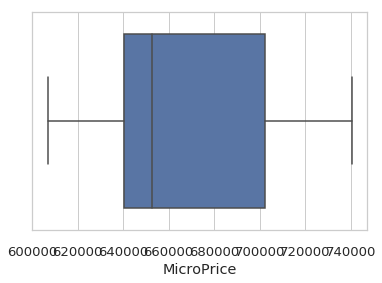

In [12]:
mad = mad_outlier(df.MicroPrice.values.reshape(-1,1))
_=sns.boxplot(df.loc[~mad].MicroPrice*100)

In [13]:
df.columns.values

array(['bestBidPrice', 'bestBidSize', 'bestAskPrice', 'bestAskSize',
       'timestamp', 'time', 'date', 'milliSeconds', 'duration',
       'MicroPrice', 'MicroPriceReturns', 'logRetMicroPrice'],
      dtype=object)

In [14]:

s1=df.bestAskSize
s2=df.bestBidSize
df['v']=pd.concat([s1, s2], axis=1).min(axis=1)
# np.min(df.bestAskSize, df.bestBidPrice)
df['dv']= df.v*df.MicroPrice

/home/ak/virtualenvs/DataAnalysis/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/ak/virtualenvs/DataAnalysis/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [15]:
n_ticks = df.shape[0]
volume_ratio = (df.v.sum()/n_ticks).round()
dollar_ratio = (df.dv.sum()/n_ticks).round()
print('num ticks:', n_ticks)
print('volume ratio:', volume_ratio)
print('dollar ratio:', dollar_ratio)

('num ticks:', 27684849)
('volume ratio:', 444902.0)
('dollar ratio:', 2977671812.0)


In [16]:
tick_M = 100 # arbitrary
print('tick threshold:', tick_M)
tidx = tick_bars(df, 'MicroPrice', tick_M)
tidx[:10]



  1%|          | 334228/27684849 [00:00<00:08, 3342275.22it/s]

('tick threshold:', 100)


100%|██████████| 27684849/27684849 [00:05<00:00, 4776528.27it/s]


[99, 199, 299, 399, 499, 599, 699, 799, 899, 999]

In [17]:


tick_df = tick_bar_df(df, 'MicroPrice', tick_M)
tick_df.shape



100%|██████████| 27684849/27684849 [00:05<00:00, 4729616.67it/s]


(276848, 14)

In [21]:
tick_df.head(5)
df.head(5)

,bestBidPrice,bestBidSize,bestAskPrice,bestAskSize,timestamp,time,date,milliSeconds,duration,MicroPrice,MicroPriceReturns,logRetMicroPrice,v,dv
1,6696.5,1176646.0,6697.0,426856.0,2018-08-26 13:21:38.017000+00:00,13:21:38.017000,2018-08-26,48098000.0,1000.0,6696.633101,-1.239604e-09,-1.239604e-09,426856.0,2.858498e+09
2,6696.5,1176296.0,6697.0,426856.0,2018-08-26 13:21:38.304000+00:00,13:21:38.304000,2018-08-26,48098000.0,0.0,6696.633130,4.339290e-09,4.339292e-09,426856.0,2.858498e+09
3,6696.5,1176296.0,6697.0,424112.0,2018-08-26 13:21:38.338000+00:00,13:21:38.338000,2018-08-26,48098000.0,0.0,6696.632501,-9.393097e-08,-9.393097e-08,424112.0,2.840122e+09
4,6696.5,1176296.0,6697.0,424112.0,2018-08-26 13:21:38.465000+00:00,13:21:38.465000,2018-08-26,48098000.0,0.0,6696.632501,0.000000e+00,0.000000e+00,424112.0,2.840122e+09
5,6696.5,1176296.0,6697.0,418112.0,2018-08-26 13:21:38.563000+00:00,13:21:38.563000,2018-08-26,48098000.0,0.0,6696.631118,-2.065148e-07,-2.065148e-07,418112.0,2.799942e+09


In [19]:
def select_sample_data(ref, sub, price_col, idx_1,idx_2):
    '''
    select a sample of data based on date, assumes datetimeindex
    
    # args
        ref: pd.DataFrame containing all ticks
        sub: subordinated pd.DataFrame of prices
        price_col: str(), price column
        date: str(), date to select
    # returns
        xdf: ref pd.Series
        xtdf: subordinated pd.Series
    '''
    xdf = df[price_col].iloc[idx_1:idx_2]
    xtdf = sub[price_col].iloc[idx_1:idx_2]
    return xdf, xtdf

## try different dates to see how the quantity of tick bars changes
idx_1=0
idx_2=10000
xdf, xtdf = select_sample_data(df, tick_df, 'MicroPrice', idx_1,idx_2)

xdf.shape, xtdf.shape

((10000,), (10000,))

In [26]:
def plot_sample_data(ref, sub, bar_type, *args, **kwds):
    f,axes=plt.subplots(3,sharex=True, sharey=True, figsize=(10,7))
    ref.plot(*args, **kwds, ax=axes[0], label='price')
    sub.plot(*args, **kwds, ax=axes[0], marker='X', ls='', label=bar_type)
    axes[0].legend();
    
    ref.plot(*args, **kwds, ax=axes[1], label='price', marker='o')
    sub.plot(*args, **kwds, ax=axes[2], ls='', marker='X',
             color='r', label=bar_type)

    for ax in axes[1:]: ax.legend()
    plt.tight_layout()
    
    return

plot_sample_data(xdf, xtdf, 'tick bar', alpha=0.5, markersize=7)


SyntaxError: invalid syntax (<ipython-input-26-8d9027afaf6a>, line 3)

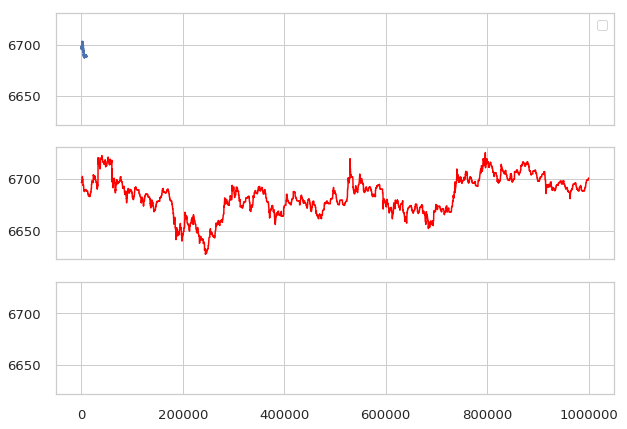

In [30]:
ref = xdf
sub
f,axes=plt.subplots(3,sharex=True, sharey=True, figsize=(10,7))
sns.lineplot(data=data,ax=axes[0], palette="tab10", linewidth=2.5)

sns.lineplot(data=xtdf,ax=axes[1],palette="tab25",color='red',linestyle='-' ,linewidth=1.5)

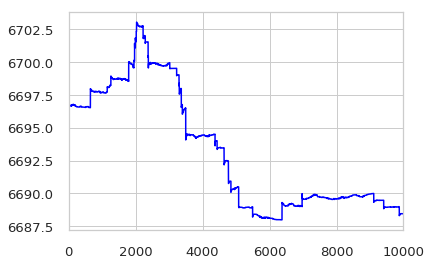

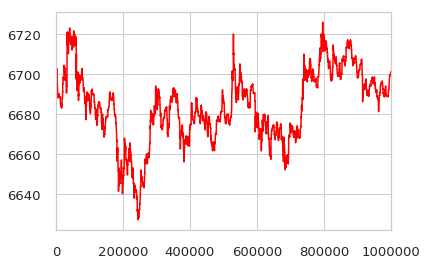

In [23]:
bar_type='tick bar'
# fig,axes=plt.subplots(3, figsize=(10,7))
ref=xdf
sub=xtdf
ref.plot(color='blue',label='price')
plt.show()
sub.plot(color='red',label=bar_type)
plt.show()


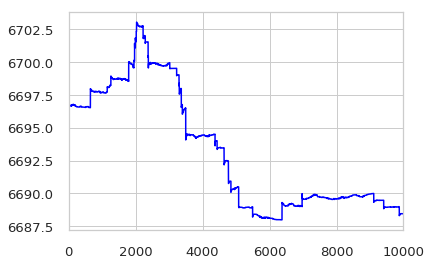

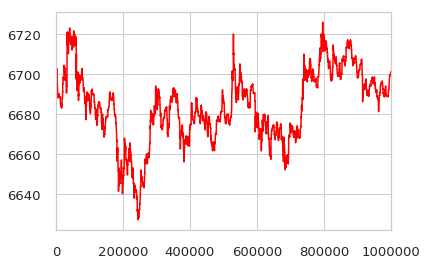

In [24]:
ax = ref.plot(color='blue',label='price')
# ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.00f}'))
plt.show()
ax2 = sub.plot(color='red',label=bar_type)
num_ticks = 10

plt.show()

In [ ]:

fig, axs = plt.subplots(2, 1,sharey=True)
axs[0].plot(ref)
axs[1].plot(sub, color= 'red',linestyle='--')
# axs[0].set_xlim(0, 2)

axs[0].grid(True)

for axs in axes:
    axs.set_xlabel('Common x-label')
    axs.set_ylabel('Common y-label')

fig.tight_layout()
plt.show()

In [ ]:

sns.distplot(sub)
sns.distplot(ref)

In [25]:
def autocorr(x):
    n = x.size
    norm = (x - np.mean(x))
    result = np.correlate(norm, norm, mode='same')
    acorr = result[n//2 + 1:] / (x.var() * np.arange(n-1, n//2, -1))
    lag = np.abs(acorr).argmax() + 1
    r = acorr[lag-1]        
    if np.abs(r) > 0.5:
        print('Appears to be autocorrelated with r = {}, lag = {}'. format(r, lag))
    else: 
        print('Appears to be not autocorrelated')
    return r, lag


In [ ]:
autocorr(df['microPrice'])

In [ ]:
df['Sqrd_returns']=(df['returns']**2)*100

In [ ]:
df['Sqrd_returns'].plot()

In [ ]:
import statsmodels as sts
# Importing lag_plot
from pandas import lag_plot
from pandas import autocorrelation_plot


In [ ]:
series = df.MicroPrice

import pandas as pd
from pandas import datetools

In [ ]:
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# # plot_acf(series)
# # plt.show()
# # # plot_pacf(series)
# # # plt.show()

In [ ]:
sns.lmplot(x='microPrice', y='Sqrd_returns', data=df)
#do calculation using high and low

In [ ]:
import powerlaw
import mpmath

In [ ]:
# fit_returns_discrete = powerlaw.Fit(df.logRetMicroPrice, discrete=False) 
# fitwolf = powerlaw.Fit(Wolfdata, discrete=True)

In [ ]:
df.shape

In [ ]:
print("For the Generated Data")
print("Max Likelihood Estimate of Alpha: %5.3f" % (fitgen.power_law.alpha)) 
cutoffString_gen = '{:,.2f}'.format(fitgen.power_law.xmin)  # I'm just formatting the output
print("Cutoff value, xmin:  "+cutoffString_gen)

In [ ]:
m

In [ ]:
df_crypto.columns.values

In [ ]:
tick_M = 20 # arbitrary
print('tick threshold:', tick_M)
tidx = tick_bars(df_crypto, 'MicroPrice', tick_M)
tidx[:10]


In [ ]:
crypto_tick_df = tick_bar_df(df_crypto, 'MicroPrice', tick_M)
crypto_tick_df.shape

In [ ]:
## try different dates to see how the quantity of tick bars changes
idx_1=0
idx_2=1000000
# perp_xdf, perp_xtdf = select_sample_data(df_crypto, crypto_tick_df, 'MicroPrice', idx_1,idx_2)

# perp_xdf.shape, perp_xtdf.shape
crypto_tick_df.head(4)

In [ ]:
btc_xdf

In [ ]:
data = perp_xdf

sns.lineplot(data=perp_xdf, palette="tab10", linewidth=2.5)
plt.show()
sns.lineplot(data=perp_xtdf,palette="tab25",color='red',linestyle='-' ,linewidth=1.5)